In [1]:
import logging
import torch
import dgl
import random
import numpy as np
from dataloader import DataLoaderHGNN
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns

/home/hieunt/anaconda3/envs/cfil/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Args:
    seed = 123
    task = 'rec'
    data_name = 'douban_movie'
    data_dir = 'data/'
    use_pretrain = 0
    pretrain_embedding_dir = 'datasets/pretrain/'
    cf_batch_size = 90000
    kg_batch_size = 10000
    nd_batch_size = 5000
    rl_batch_size = 1
    train_batch_size = 2000
    test_batch_size = 20000
    entity_dim = 64
    relation_dim = 32
    aggregation_type = 'bi-interaction'
    log = ''

In [4]:
seed(0)
args=Args()
infor = 'rl_' + str(args.data_name) + '_' + str(args.task) + '_' + str(args.log)
model_name = 'model_' + infor + '.pth'
dataset = args.data_name
logger1 = get_logger('log', 'log/logger_' + infor + '.log')
logger2 = get_logger('log2', 'log/logger2_' + infor + '.log')

In [5]:
data = DataLoaderHGNN(logger1, args, dataset)

## Data Info

### Douban Movie

Node type: 

Movie: 0 (0 - 12676) Actor: 1 (12677 - 18987), Director: 2 (18988 - 21436),
                Type : 3 (21437 - 21474), Group: 4 (21475 - 24227), User: 5 (24228 - 37594)

Relations (Edges): 
- 1: M-U 
- 2: U-M 
- 3: M-A 
- 4: M-D 
- 5: M-T 
- 6: U-G 
- 7: U-U 
- 8: A-M 
- 9: D-M 
- 10: T-M 
- 11: G-U 
- 12: U-U

In [12]:
edge_map = {
    'MU': (1, [0, 5]),
    'UM': (2, [5, 0]),
    'MA': (3, [0, 1]),
    'MD': (4, [0, 2]),
    'MT': (5, [0, 3]),
    'UG': (6, [5, 4]),
    'UU': (7, [5, 5]),
    'AM': (8, [1, 0]),
    'DM': (9, [2, 0]),
    'TM': (10, [3, 0]),
    'GU': (11, [4, 5])
    }

In [6]:
def get_node_edge_list(metapath='UMAM'):
    node_type_list = []
    edge_type_list = []
    for i in range(1, len(metapath)):
        node_type_list = node_type_list + edge_map[metapath[i-1:i+1]][1]
        edge_type_list.append(str(edge_map[metapath[i-1:i+1]][0]))
    
    node_type_list = list(set(node_type_list))
    for i in range(len(node_type_list)):
        node_type_list[i] = 'n' + str(node_type_list[i])
    
    return node_type_list + ['n0.1'], edge_type_list

def get_subgraph(graph, node_type_list, edge_type_list, node_id=None, node_type='n5', k=2): 
    
    sgraph = graph.node_type_subgraph(node_type_list)
    sgraph = sgraph.edge_type_subgraph(edge_type_list)
    if node_id is not None:
        sgraph = sgraph.khop_out_subgraph({node_type: node_id}, k=k)

    if isinstance(sgraph, tuple):
        return sgraph[0]
    else:
        return sgraph

def draw_subgraph(heter_subgraph):
    homo_graph = dgl.to_homogeneous(heter_subgraph)
    homo_graph = dgl.to_networkx(homo_graph)
    nodelist = list(homo_graph.nodes())
    edgelist = list(homo_graph.edges())
    pos = nx.kamada_kawai_layout(homo_graph)
    pos_nodelist = {k: v for k, v in pos.items() if k in nodelist}
    nx.draw_networkx_nodes(homo_graph, pos,
                                nodelist=list(homo_graph.nodes()),
                                node_color='#FFA500',
                                node_size=200, label = np.arange(len(nodelist)))

    nx.draw_networkx_edges(homo_graph, pos, width=2, edge_color='gray', arrows=True)

    plt.axis('off')


In [17]:
node_type_list, edge_type_list = get_node_edge_list()
subgraph = get_subgraph(data.train_graph, node_type_list, edge_type_list, 35637 - 24228)
subgraph

Graph(num_nodes={'n0': 11, 'n0.1': 361, 'n1': 36, 'n5': 1},
      num_edges={('n5', '2', 'n0'): 11, ('n0', '3', 'n1'): 36, ('n1', '8', 'n0.1'): 404},
      metagraph=[('n0', 'n1', '3'), ('n1', 'n0.1', '8'), ('n5', 'n0', '2')])

In [15]:
node_type_list, edge_type_list = get_node_edge_list()
subgraph = get_subgraph(data.train_graph, node_type_list, edge_type_list, 5, k=3)
subgraph

Graph(num_nodes={'n0': 2, 'n0.1': 70, 'n1': 4, 'n5': 1},
      num_edges={('n5', '2', 'n0'): 2, ('n0', '3', 'n1'): 4, ('n1', '8', 'n0.1'): 73},
      metagraph=[('n0', 'n1', '3'), ('n1', 'n0.1', '8'), ('n5', 'n0', '2')])

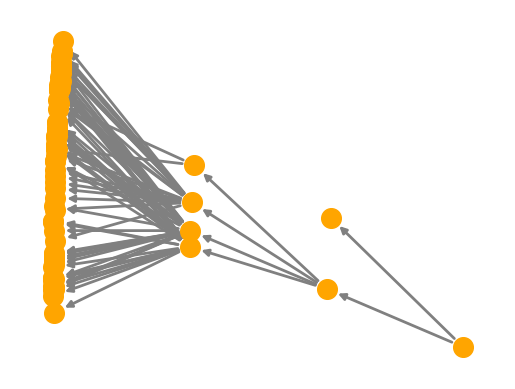

In [16]:
draw_subgraph(subgraph)

In [42]:
node_type_list, edge_type_list = get_node_edge_list()
subgraph = get_subgraph(data.train_graph, node_type_list, edge_type_list, 36739 - 24228, k = 3)
subgraph

Graph(num_nodes={'n0': 3, 'n0.1': 142, 'n1': 9, 'n5': 1},
      num_edges={('n5', '2', 'n0'): 3, ('n0', '3', 'n1'): 9, ('n1', '8', 'n0.1'): 149},
      metagraph=[('n0', 'n1', '3'), ('n1', 'n0.1', '8'), ('n5', 'n0', '2')])

In [36]:
s = dgl.node_subgraph(subgraph, {'n5': subgraph.nodes('n5'), 'n0': subgraph.nodes('n0'), 'n1': subgraph.nodes('n1'), 'n0.1': subgraph.nodes('n0') })

In [37]:
s

Graph(num_nodes={'n0': 3, 'n0.1': 3, 'n1': 9, 'n5': 1},
      num_edges={('n5', '2', 'n0'): 3, ('n0', '3', 'n1'): 9, ('n1', '8', 'n0.1'): 3},
      metagraph=[('n0', 'n1', '3'), ('n1', 'n0.1', '8'), ('n5', 'n0', '2')])

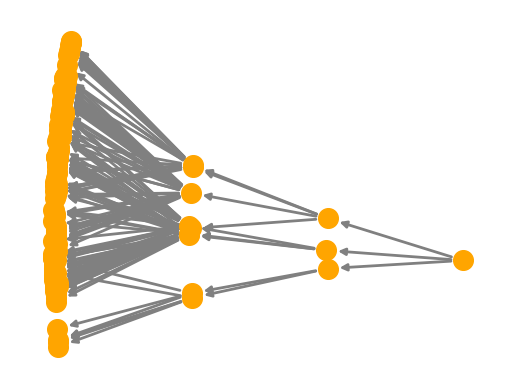

In [43]:
draw_subgraph(subgraph)

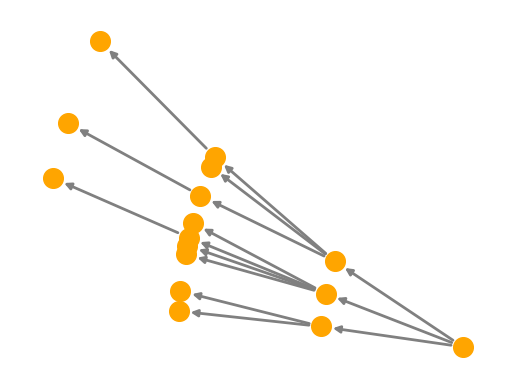

In [39]:
draw_subgraph(s)

In [25]:
num_node_layer_2 = []
num_node_layer_3 = []
num_node_layer_4 = []
for node_id in data.train_graph.nodes('n5'):
    subgraph = get_subgraph(data.train_graph, ['n0', 'n5', 'n1', 'n0.1'], ['2', '3', '8'], node_id)
    num_node_layer_2.append(subgraph.num_nodes('n0'))
    num_node_layer_3.append(subgraph.num_nodes('n1'))
    num_node_layer_4.append(subgraph.num_nodes('n0.1'))    

In [62]:
num_actors_in_movie = []
for movie_id in data.train_graph.nodes('n0'):
    subgraph = get_subgraph(data.train_graph, ['n0', 'n1'], ['3'], node_id=movie_id, node_type='n0', k=1)
    num_actors_in_movie.append(subgraph.num_nodes('n1'))

In [101]:
for movie_id in data.train_graph.nodes('n0'):
    subgraph = get_subgraph(data.train_graph, ['n0', 'n1'], ['3'], node_id=movie_id, node_type='n0', k=1)
    num_actors_in_movie.append(subgraph.num_nodes('n1'))
    if subgraph.num_nodes('n1') == 0:
        print(movie_id)
        

tensor(17)
tensor(23)
tensor(28)
tensor(34)
tensor(46)
tensor(54)
tensor(56)
tensor(74)
tensor(81)
tensor(85)
tensor(91)
tensor(101)
tensor(142)
tensor(148)
tensor(156)
tensor(187)
tensor(227)
tensor(231)
tensor(236)
tensor(237)
tensor(250)
tensor(259)
tensor(267)
tensor(274)
tensor(275)
tensor(276)
tensor(281)
tensor(282)
tensor(284)
tensor(293)
tensor(299)
tensor(305)
tensor(306)
tensor(315)
tensor(321)
tensor(326)
tensor(340)
tensor(342)
tensor(344)
tensor(348)
tensor(350)
tensor(357)
tensor(358)
tensor(376)
tensor(379)
tensor(385)
tensor(386)
tensor(401)
tensor(425)
tensor(452)
tensor(497)
tensor(499)
tensor(504)
tensor(520)
tensor(521)
tensor(542)
tensor(674)
tensor(713)
tensor(714)
tensor(767)
tensor(787)
tensor(838)
tensor(878)
tensor(886)
tensor(888)
tensor(924)
tensor(937)
tensor(938)
tensor(978)
tensor(988)
tensor(1014)
tensor(1034)
tensor(1146)
tensor(1156)
tensor(1164)
tensor(1279)
tensor(1297)
tensor(1302)
tensor(1368)
tensor(1411)
tensor(1417)
tensor(1418)
tensor(1429)
te

KeyboardInterrupt: 

In [102]:
data.train_graph.khop_in_subgraph({'n0': [275]}, k=1)[0].nodes('n5')

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [87]:
data.kg_test_data

,h,r,t,ht,tt
0,1929,3,12677,0,1
1,3139,3,12677,0,1
2,3596,3,12677,0,1
3,4661,3,12677,0,1
4,4883,3,12677,0,1
...,...,...,...,...,...
1686683,10136,1,36427,0,5
1686684,10072,1,36427,0,5
1686685,5017,1,36427,0,5
1686686,4892,1,36427,0,5


,Number of actors in a movie
count,12677.000000
mean,2.648261
std,1.281178
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


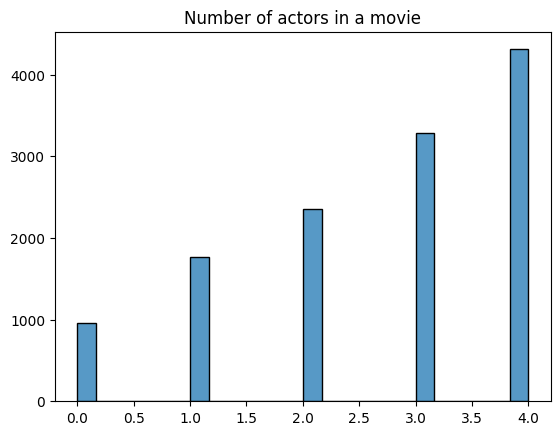

In [64]:
sns.histplot(num_actors_in_movie).set(xlabel='', ylabel='', title='Number of actors in a movie')
df = pd.DataFrame(num_actors_in_movie, columns=['Number of actors in a movie'])
df.describe()

In [73]:
num_movies_by_actor = []
for actor_id in data.train_graph.nodes('n1'):
    subgraph = get_subgraph(data.train_graph, ['n0.1', 'n1'], ['8'], node_id=actor_id, node_type='n1', k=1)
    num_movies_by_actor.append(subgraph.num_nodes('n0.1'))

,Number of movies acted by a actor
count,6311.000000
mean,5.319601
std,5.506290
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,68.000000


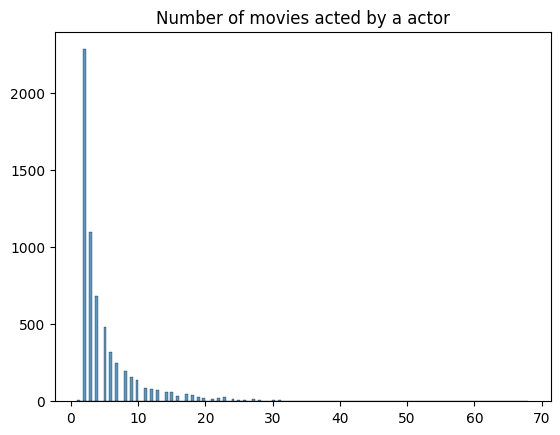

In [74]:
sns.histplot(num_movies_by_actor).set(xlabel='', ylabel='', title='Number of movies acted by a actor')
df = pd.DataFrame(num_movies_by_actor, columns=['Number of movies acted by a actor'])
df.describe()

In [52]:
for movie_id in data.train_graph.nodes('n0'):
    subgraph = get_subgraph(data.train_graph, ['n0', 'n1'], ['3'], )
    num_actor_in_movie.append(subgraph.num_nodes('n0'))

Graph(num_nodes={'n0': 12677, 'n1': 6311},
      num_edges={('n0', '3', 'n1'): 33572},
      metagraph=[('n0', 'n1', '3')])

In [27]:


for node_id in data.train_graph.nodes('n5'):
    subgraph = get_subgraph(data.train_graph, ['n0', 'n1'], ['3'])
    num_actor_in_movie.append(subgraph.num_nodes('n0'))
get_subgraph(data.train_graph, node_type_list=['n1', 'n0'], edge_type_list=['3'])

In [34]:
import pandas as pd 

[Text(0.5, 1.0, 'Number of nodes layer 2 (Movies)')]

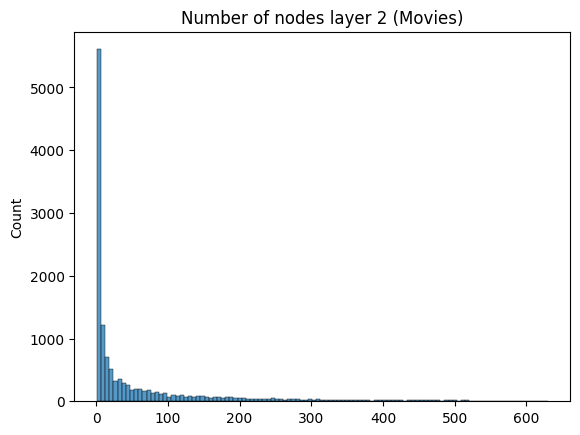

In [29]:
sns.histplot(num_node_layer_2).set(xlabel='', ylabel='', title='Number of nodes layer 2 (Movies)')

In [37]:
df = pd.DataFrame(num_node_layer_2, columns=['Number of nodes layer 2 - Movies'])
df.describe()

,Number of nodes layer 2 - Movies
count,13367.000000
mean,63.972694
std,110.564906
min,1.000000
25%,2.000000
50%,12.000000
75%,71.000000
max,630.000000


,Number of nodes layer 3 - Actors
count,13367.000000
mean,157.967682
std,243.530972
min,0.000000
25%,7.000000
50%,37.000000
75%,204.000000
max,1253.000000


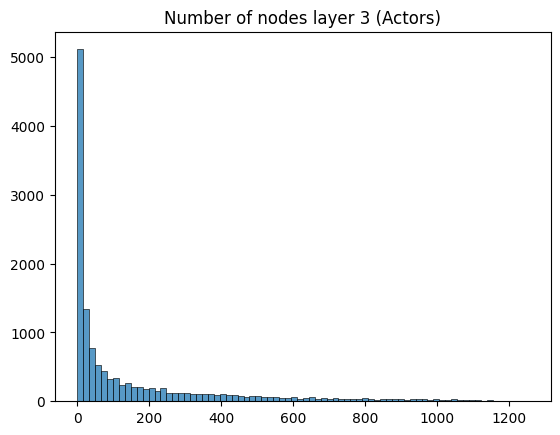

In [39]:
sns.histplot(num_node_layer_3).set(xlabel='', ylabel='', title='Number of nodes layer 3 (Actors)')
df = pd.DataFrame(num_node_layer_3, columns=['Number of nodes layer 3 - Actors'])
df.describe()

,Number of nodes layer 4 - Movies duplicate
count,13367.000000
mean,1288.489713
std,1634.770076
min,0.000000
25%,84.500000
50%,441.000000
75%,2044.000000
max,6904.000000


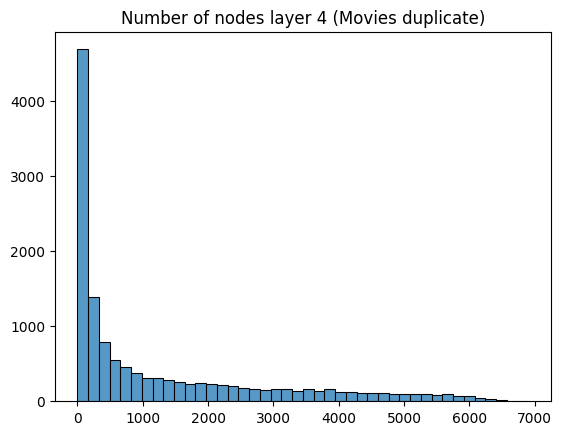

In [40]:
sns.histplot(num_node_layer_4).set(xlabel='', ylabel='', title='Number of nodes layer 4 (Movies duplicate)')
df = pd.DataFrame(num_node_layer_4, columns=['Number of nodes layer 4 - Movies duplicate'])
df.describe()

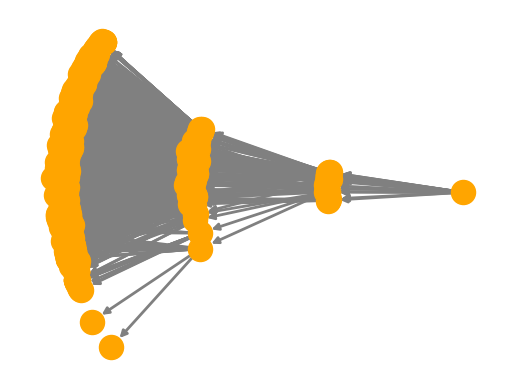

In [100]:
draw_subgraph(subgraph)

In [7]:
# metapath: U - M - A - M
sgraph = data.train_graph.node_type_subgraph(['n0', 'n5', 'n1', 'n0.1'])
sgraph = sgraph.edge_type_subgraph(['2', '3', '8'])
sgraph = sgraph.khop_out_subgraph({'n5': 29830 - 24228}, k=2)

In [9]:
draw_subgraph(sgraph)

AttributeError: 'tuple' object has no attribute 'ntypes'

(-0.27069660103849863,
 1.120744925890536,
 -0.3446988099744437,
 0.28677800712381774)

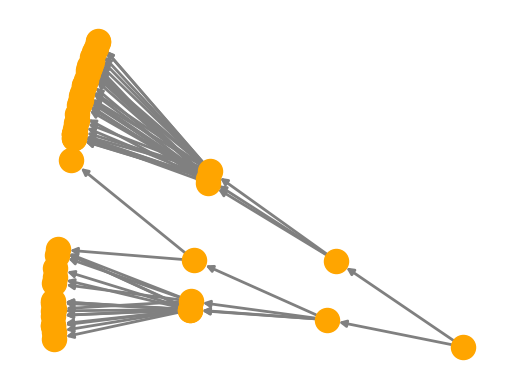

In [8]:
homo_graph = dgl.to_homogeneous(sgraph[0])
homo_graph = dgl.to_networkx(homo_graph)
nodelist = list(homo_graph.nodes())
edgelist = list(homo_graph.edges())
pos = nx.kamada_kawai_layout(homo_graph)
pos_nodelist = {k: v for k, v in pos.items() if k in nodelist}
nx.draw_networkx_nodes(homo_graph, pos,
                               nodelist=list(homo_graph.nodes()),
                               node_color='#FFA500',
                               node_size=300, label = np.arange(len(nodelist)))

nx.draw_networkx_edges(homo_graph, pos, width=2, edge_color='gray', arrows=True)

plt.axis('off')